# MODELING    


dataset1- benchmark     
dataset2- our selected features (much more than dataset1)

We compared 5 models on 2 datasets: Logistic Regression, Decision Tree, XGBoost,KNN,CNN
1. We perform propressing by imputer missing data and normalize data 
2. We split 2 datasets into features and lables for test(0.2) and train(0.8)
3. We plot ROC curves for default models on datasets to roughly estimate the performance
(result may change after parameter turing)
4. We perform hyperparameter selection by grid search and cross validation
5. We fit model and predict test result based on tured models 
6. We compare model performance for two datasets and choose the best model-- XGBoost   
-XBGoost is much better than other models(it is suitable for sparse hign dimension data)    
-KNN performs better on dataset1(with less features) than set2(150 features)
-CNN achieves good performance but not outstanding(maybe not enough data or enough tuning) . On the other hand, we think our data is not a sequential signal so may not achieve best performance on 1D CNN.
-Tured decision tree is much better than origin one(reduce bias)
-Logistic regression is on average performance
7. Look into testing result for XGBoost on dataset2 for feature importance
8. We find the results on two datasets are not far away from each other. And we believe it is because the data is sparse, so even when adding more data, it cannot reduce variance largely. On the other hand, the 17 features in the dataset1 are more dense. So it can perform well even it has few features. Moreover,  since the features in first dataset are commonly used in history, it means they are important features generally.    


In [0]:
'''
Remaining problems:
1. Two datasets 
use SOPAS as benchmark - dataset1
2. add demographics features to the dataset2
3. inconsistent units in dataset2
4. feature dimensionality reduction?
5. visualizations(correlation heatmap, avg/min/max gender...)
6. convert >1000 to 80% \/
7. outliers, missing values
8. admission time filter - less than a year \/
9. weighted mean for time series data 
10. categorize features - heart rate..
11. research mortality 
12. normalize data 
'''
import pandas as pd

import xgboost as xgb

from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import plot_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
from scipy import interp
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint

In [2]:
# for google collab
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
# for google colab
%cd /gdrive/My\ Drive/Colab Notebooks

/gdrive/My Drive/Colab Notebooks


### DATA PREPROCESSING

In [0]:
final_final = pd.read_csv('final_final.csv')
final_df17 = pd.read_csv('final_df17.csv')
final_final.rename(columns={'1_yr_mortality_':'1_yr_mortality'}, inplace=True)

#### extract features

In [0]:
def preprocess(final_final):
  final_final = final_final.loc[:,~final_final.columns.str.contains('^Unnamed')]
  #y_df = final_final['1_yr_mortality_']
  #x_df = final_final.loc[:, final_final.columns != '1_yr_mortality_']
  y_df = final_final['1_yr_mortality']
  x_df = final_final.loc[:, final_final.columns != '1_yr_mortality']
  x_df = x_df.loc[:, x_df.columns != 'HADM_ID']
  x_df = x_df.drop('ADMITTIME',axis=1)
  x_df = x_df.drop('DOB',axis=1)
  # Imputer using mean
  imp = Imputer(missing_values=np.nan, strategy='mean')
  x_df = imp.fit_transform(x_df)
  x_df = pd.DataFrame(x_df)
  scaler = StandardScaler()
  x_df = scaler.fit_transform(x_df)
  x_df = pd.DataFrame(x_df)
  return x_df,y_df

In [9]:
x_df,y_df=preprocess(final_final)
x_df17,y_df17=preprocess(final_df17)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
print(x_df.shape,x_df17.shape)

(56730, 150) (56730, 39)


#### Split data and initialize model parameters

In [0]:
x_df_train, x_df_test, y_df_train, y_df_test = train_test_split(x_df, y_df, test_size=0.2)

In [0]:
x_df17_train, x_df17_test, y_df17_train, y_df17_test = train_test_split(x_df17, y_df17, test_size=0.2)

In [0]:
class_weight_scale = 1.*y_df.value_counts()[0]/y_df.value_counts()[1]

In [15]:
param={
    'objective':'binary:logistic',
    'nthread':4,
    'scale_pos_weight':class_weight_scale,
    'seed' : 1   
}
xgb1 = XGBClassifier()
xgb1.set_params(**param)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=3.486713065485606,
       seed=1, silent=True, subsample=1)

### Plot train ROC curves and test accuracy for defualt models

In [0]:
def Plot_ROC(classifier, title, x, y):
    K = 5
    eval_size = int(np.round(1./K))
    skf = StratifiedKFold(n_splits=K)

    fig = plt.figure(figsize=(7,7))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    lw = 2
    i = 0
    roc_aucs_xgb1 = []
    for train_indices, test_indices in skf.split(x, y):
        X_train, y_train = x.iloc[train_indices], y.iloc[train_indices]
        X_valid, y_valid = x.iloc[test_indices], y.iloc[test_indices]
        if classifier == "xgb1":
            class_weight_scale = 1.*y_train.value_counts()[0]/y_train.value_counts()[1]
            print('class weight scale : {}'.format(class_weight_scale))
            classifier.set_params(**{'scale_pos_weight' : class_weight_scale})
        classifier.fit(X_train,y_train)
        classifier_pred_prob = classifier.predict_proba(X_valid)
        fpr, tpr, thresholds = roc_curve(y_valid, classifier_pred_prob[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        roc_aucs_xgb1.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

    mean_tpr /= K
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    
    
#fig.savefig('figures/initial_ROC.png')

In [0]:
def testdata(classifier,name, x_train, y_train,x_test,y_test):
   
    if classifier == "xgb1":
        class_weight_scale = 1.*y_train.value_counts()[0]/y_train.value_counts()[1]
        print('class weight scale : {}'.format(class_weight_scale))
        classifier.set_params(**{'scale_pos_weight' : class_weight_scale})
    classifier.fit(x_train,y_train)
    classifier_pred= classifier.score(x_test,y_test)
    print('acc for',name,classifier_pred)

    

In [44]:
testdata(xgb1,'xgb:',x_df_train, y_df_train,x_df_test,y_df_test)

xgb: 0.761237440507668


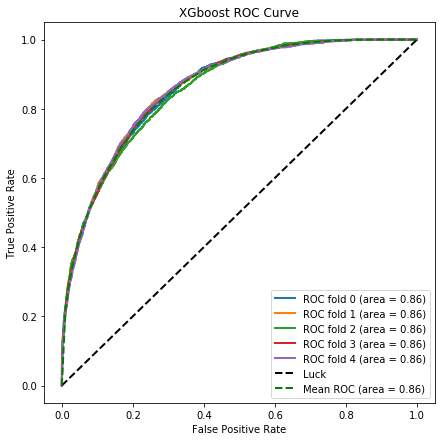

In [45]:
Plot_ROC(xgb1, "XGboost ROC Curve", x_df_train, y_df_train)

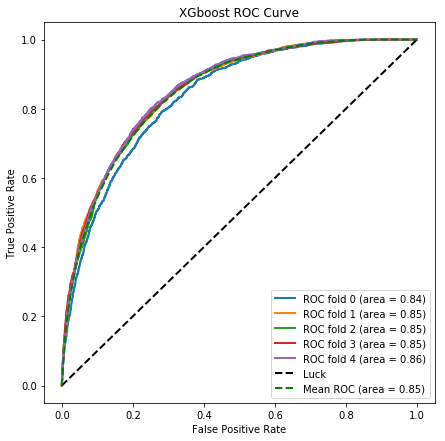

In [85]:
Plot_ROC(xgb1, "XGboost ROC Curve", x_df17_train, y_df17_train)

In [86]:
testdata(xgb1,'xgb:',x_df17_train, y_df17_train,x_df17_test,y_df17_test)

acc for xgb: 0.7579763793407368


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWar

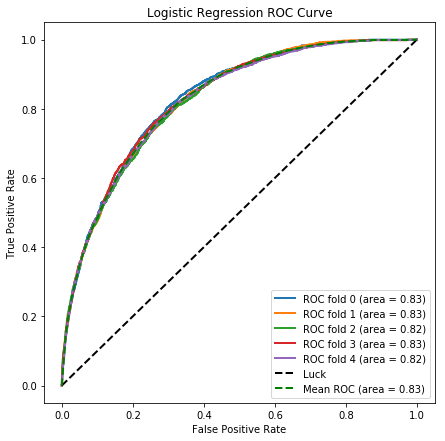

In [88]:
logistic = LogisticRegression(penalty='l1')
Plot_ROC(logistic, "Logistic Regression ROC Curve",x_df_train, y_df_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

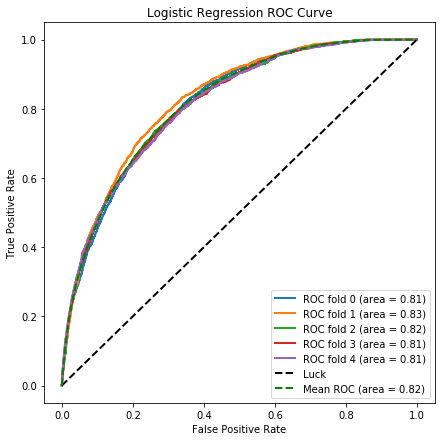

In [66]:
Plot_ROC(logistic, "Logistic Regression ROC Curve", x_df17_train, y_df17_train)

In [67]:
testdata(logistic,'logistic:',x_df17_train, y_df17_train,x_df17_test,y_df17_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


acc for logistic: 0.8154415653093601


In [68]:
testdata(logistic,'logistic:',x_df_train, y_df_train,x_df_test,y_df_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


acc for logistic: 0.817028027498678


In [0]:
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier()

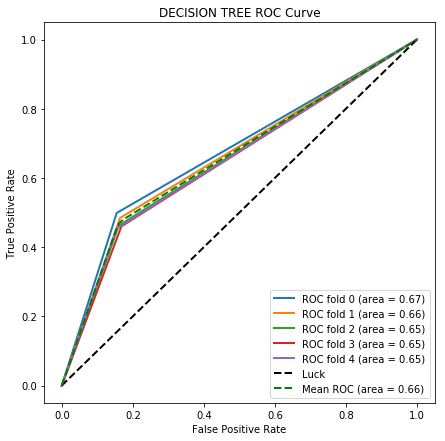

In [91]:
Plot_ROC(decisiontree, "DECISION TREE ROC Curve", x_df17_train, y_df17_train)

In [92]:
testdata(decisiontree,'decision tree:',x_df17_train, y_df17_train,x_df17_test,y_df17_test)

acc for decision tree: 0.7620306716023268


acc for decision tree: 0.7693460250308479


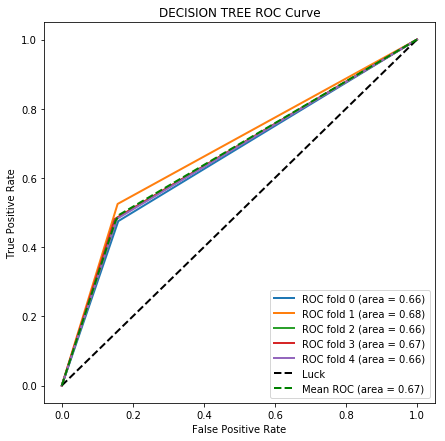

In [93]:
Plot_ROC(decisiontree, "DECISION TREE ROC Curve", x_df_train, y_df_train)
testdata(decisiontree,'decision tree:',x_df_train, y_df_train,x_df_test,y_df_test)

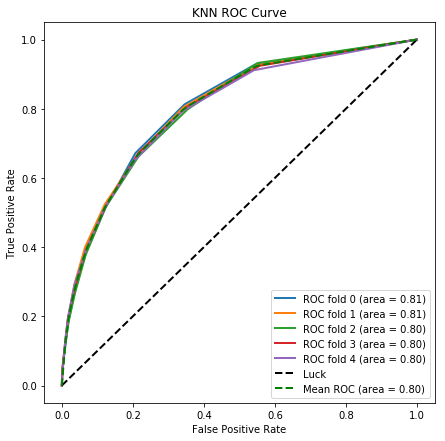

In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=10)
Plot_ROC(knn_clf, "KNN ROC Curve", x_df17_train, y_df17_train)


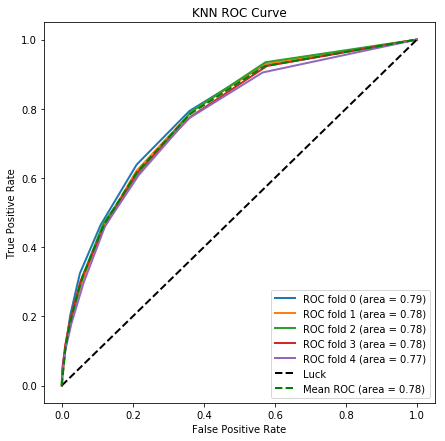

In [58]:
Plot_ROC(knn_clf, "KNN ROC Curve", x_df_train, y_df_train)

In [57]:
testdata(knn_clf,'cnn:',x_df17_train, y_df17_train,x_df17_test,y_df17_test)

acc for cnn: 0.8181738057465185


In [59]:
testdata(knn_clf,'cnn:',x_df_train, y_df_train,x_df_test,y_df_test)

acc for cnn: 0.8043363299841354


###  Tune hyperparameters with Grid search (we can first search in coarse range and then shrink )
### Fit best tuned models to predict testing data and compare test accuracies  

###CNN   
(We obtain proper epoch by obeserve training and validation acc)


In [0]:
  #Sequence classification with 1D convolutions:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D


def CNN(x_df17_train, y_df17_train,x_df17_test,y_df17_test):
  
  r,c = x_df17_train.shape
  X_train=x_df17_train.values.reshape(r,c, 1)

  model = Sequential()
  model.add(Conv1D(32, 3, activation='relu', input_shape=(c, 1)))
  model.add(Conv1D(32, 3, activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(Conv1D(32, 3, activation='relu'))
  model.add(Conv1D(32, 3, activation='relu'))
  model.add(GlobalAveragePooling1D())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  history=model.fit(X_train, y_df17_train, validation_split=0.2, batch_size=100, epochs=20)
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])  
  plt.plot(history.history['val_acc'])
  plt.title('CNN accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  row,col = x_df17_test.shape
  X_test=x_df17_test.values.reshape(row, col, 1)
  score = model.evaluate(X_test, y_df17_test, batch_size=100)
  print("acc for cnn",score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 36307 samples, validate on 9077 samples
Epoch 1/20
36307/36307 [==============================] - 5s 143us/step - loss: 0.5096 - acc: 0.7783 - val_loss: 0.4776 - val_acc: 0.7764
Epoch 2/20
36307/36307 [==============================] - 5s 130us/step - loss: 0.4659 - acc: 0.7916 - val_loss: 0.4567 - val_acc: 0.7883
Epoch 3/20
36307/36307 [==============================] - 4s 120us/step - loss: 0.4448 - acc: 0.8016 - val_loss: 0.4247 - val_acc: 0.8046
Epoch 4/20
36307/36307 [==============================] - 4s 120us/step - loss: 0.4377 - acc: 0.8025 - val_loss: 0.4152 - val_acc: 0.8052
Epoch 5/20
36307/36307 [==============================] - 4s 121us/step - loss: 0.4252 - acc: 0.8064 - val_loss: 0.4109 - val_acc: 0.8037
Epoch 6/20
36307/36307 [==

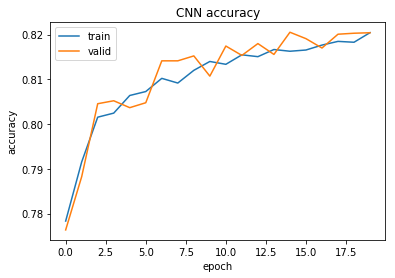

11346/11346 [==============================] - 0s 38us/step
acc for cnn 0.8143839221582324


In [106]:
CNN(x_df17_train, y_df17_train,x_df17_test,y_df17_test)

Train on 36307 samples, validate on 9077 samples
Epoch 1/30
36307/36307 [==============================] - 17s 459us/step - loss: 0.5299 - acc: 0.7749 - val_loss: 0.5040 - val_acc: 0.7773
Epoch 2/30
36307/36307 [==============================] - 14s 393us/step - loss: 0.5102 - acc: 0.7770 - val_loss: 0.4982 - val_acc: 0.7781
Epoch 3/30
36307/36307 [==============================] - 14s 393us/step - loss: 0.5024 - acc: 0.7793 - val_loss: 0.4854 - val_acc: 0.7821
Epoch 4/30
36307/36307 [==============================] - 14s 394us/step - loss: 0.4922 - acc: 0.7819 - val_loss: 0.4767 - val_acc: 0.7851
Epoch 5/30
36307/36307 [==============================] - 14s 393us/step - loss: 0.4846 - acc: 0.7837 - val_loss: 0.4737 - val_acc: 0.7875
Epoch 6/30
36307/36307 [==============================] - 14s 396us/step - loss: 0.4775 - acc: 0.7848 - val_loss: 0.4619 - val_acc: 0.7894
Epoch 7/30
36307/36307 [==============================] - 14s 398us/step - loss: 0.4706 - acc: 0.7860 - val_loss: 0.4

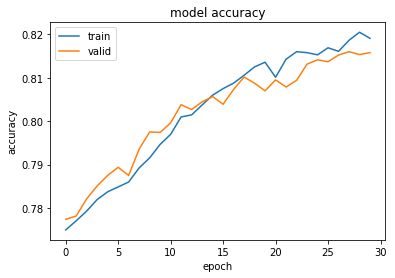

11346/11346 [==============================] - 1s 115us/step
acc for cnn 0.8124449132990421


In [86]:
CNN(x_df_train, y_df_train,x_df_test,y_df_test)

#### Decision Tree

In [0]:
params_grid = {
    'min_samples_split': list(range(2, 4)),
    'max_depth': list(range(6, 10))
}

In [0]:
bst_grid = GridSearchCV(estimator = DecisionTreeClassifier(),param_grid = params_grid,cv=3,scoring = 'accuracy')

In [17]:
bst_grid.fit(x_df_train, y_df_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 3], 'max_depth': [6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [19]:
bst_grid.best_params_

{'max_depth': 9, 'min_samples_split': 3}

In [18]:
bst_grid.best_estimator_.score(x_df_test,y_df_test)

0.8163229331923145

In [0]:
# 'mean_train_score'
# bst_grid.cv_results_
gridscore=[0.79940067, 0.80017187, 0.80290411, 0.80488718, 0.80647365,
        0.80565838, 0.802838  , 0.80259563, 0.79834303, 0.79957694]
xx=list(range(5, 15))

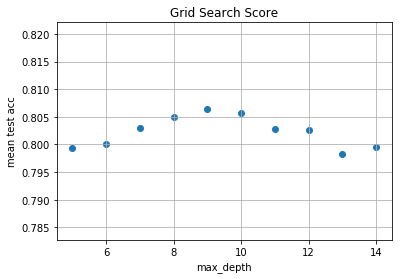

In [119]:
plt.scatter(xx,gridscore)
plt.title('Grid Search Score')
plt.ylabel('mean test acc')
plt.xlabel('max_depth')
plt.grid(True)

In [51]:
bst_grid.fit(x_df17_train, y_df17_train)
bst_grid.best_params_

{'max_depth': 9, 'min_samples_split': 2}

In [121]:
bst_grid.best_estimator_.score(x_df17_test,y_df17_test)

0.8081262118808391

#### KNN(huge computing cost)

In [37]:
params_grid = {
    'n_neighbors': [4,6,8],
}

bst_grid = GridSearchCV(estimator = KNeighborsClassifier(),param_grid = params_grid,cv=3,scoring = 'accuracy')
bst_grid.fit(x_df17_train, y_df17_train)
print("best para:",bst_grid.best_params_)
print("acc:",bst_grid.best_estimator_.score(x_df17_test,y_df17_test))

best para: {'n_neighbors': 8}
acc: 0.809536400493566


#### Logistic


In [21]:
params_grid = {
    'C': [0.01,0.1,1,10],
}
bst_grid = GridSearchCV(estimator = LogisticRegression(),param_grid = params_grid,cv=3,scoring = 'accuracy')
bst_grid.fit(x_df_train, y_df_train)
print("best para:",bst_grid.best_params_)
print("acc:",bst_grid.best_estimator_.score(x_df_test,y_df_test))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

best para: {'C': 0.01}
acc: 0.8164992067689053


#### XGBoost(High Computation Cost)

In [0]:
params_grid = {
    #"max_depth": [3,5,7,9],
    "max_depth": [7], # defualt 3
    "min_child_weight":[1,3,5] #default 1
}

In [0]:
bst_grid = GridSearchCV(estimator = XGBClassifier(),param_grid = params_grid,cv=3,scoring = 'accuracy')

In [26]:
bst_grid.fit(x_df17_train, y_df17_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [27]:
bst_grid.best_params_

{'max_depth': 7, 'min_child_weight': 3}

In [28]:
bst_grid.best_estimator_.score(x_df17_test,y_df17_test)

0.8348316587343557

In [0]:
#class_weight_scale = 1.*y_df_train.value_counts()[0]/y_df_train.value_counts()[1]

In [0]:
bst_grid = GridSearchCV(estimator = XGBClassifier(),param_grid = params_grid,cv=3,scoring = 'accuracy')

In [30]:
bst_grid.fit(x_df_train, y_df_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [31]:
bst_grid.best_params_ 

{'max_depth': 7, 'min_child_weight': 5}

In [32]:
bst_grid.best_estimator_.score(x_df_test,y_df_test)

0.8455843469063987

### Choose XGBoost as our prediction classifier 

####fit model on training set

In [0]:
XGB=XGBClassifier(max_depth=7,min_child_weight=5)

In [0]:
model=XGB.fit(x_df_train, y_df_train)

####  find important features in our training dataset on this model

In [0]:
importance=model.feature_importances_

In [0]:
ind=np.where(importance>0.016)

In [117]:
importance[ind]

array([0.02247287, 0.03523742, 0.02111692, 0.01963357, 0.02620944,
       0.0533147 , 0.1529332 , 0.06103644], dtype=float32)

#### we can find that the gain of features decrease sharply after around 10 features 

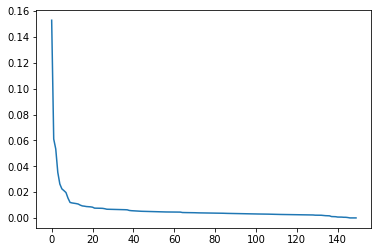

In [128]:
plt.plot(list(range(150)),importance[::-1])

In [89]:
ind

(array([ 28,  63, 107, 112, 124, 141, 144, 145]),)

### predict result on testing data

In [0]:
y_pred=bst_grid.best_estimator_.predict(x_df_test)

In [0]:
y_prob=bst_grid.best_estimator_.predict_proba(x_df_test)

In [0]:
y_pred=XGB.predict(x_df_test)

In [36]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
pred=pd.DataFrame(x_df_test)

In [0]:
pred['predy']=y_pred

#### culculate features on testing result

In [62]:
# death count
pred['predy'].value_counts()

0    9760
1    1586
Name: predy, dtype: int64

#### Calculate mean/std stats for 8 important features 

In [0]:
patient=final_final.iloc[:,3:]

In [0]:
cols=patient.columns[ind]

In [0]:
patient1=patient[patient['1_yr_mortality_']==1]

In [88]:
patient0=patient[patient['1_yr_mortality_']==0]
for c in cols:
  std=patient0[c].std()
  mean=patient0[c].mean()
  print(mean,std)

6.29937186625503 11.021816640283012
2.865981953972858 9.38748022860693
31.871117859209672 17.179570077588767
45.10692483033156 73.57745047359026
3.943567623077773 1.2366339728748763
138.7498456216154 3.2858015904500157
0.14086104432246063 0.34788210021269816
0.6693734972553645 0.4704440865413089


In [87]:
for c in cols:
  std=patient1[c].std()
  mean=patient1[c].mean()
  print(mean,std)

12.289218857174744 35.8020806470367
8.712619168815305 14.075372752212056
35.81293262883562 26.314765187240095
116.91683485324006 208.52790284238105
3.1691452529254915 1.5657739566621425
138.72065697329407 4.4657461586535065
0.05876304966782664 0.23518998365306767
0.9135558367605188 0.2810299203814637


# Suggestions

In project, we implemented five different models: decision tree, XGboost, logistic regression, KNN, and Neural Network. We chose these five models because it spans both linear and non-linear, naive and ensemble models. Among all models we selected, XGboost model performs the best. We would recommend using XGboost for 1-year-mortality prediction with 39 features. 

Both data sets perform equally well with different machine learning algorithms. Among the two data sets we selected, we did not observe significant model performance difference between the 39 features data sets and 159 feature data sets. The speculation is that due to the sparsity of the data set, the additional selected feature did not contribute as much as 39 features. The model performance could be improved on the 150 feature data sets if we could perform additional feature and patient selection. The more features being selected, the less likely that all patients will have all features. Selecting a high number of variables may bias the dataset towards selecting patients have similar conditions. Thus a better features selection process could be researched and improved.

In addition, in the 150 feature data analysis, we used the mean value for time series data. The mean value may not accurately describe the severity of a patient’s condition. The earlier icu data should weight more than later ICU data. Thus, future improvement could be carried on using weighted mean for time series data or better handling of time series data. 

# References

https://www.mcall.com/health/mc-inspire-health-how-important-is-continuity-of-care-story.html
 
Sudhakar-Krishnan, V., & Rudolf, M. C. (2007). How important is continuity of care?. Archives of disease in childhood, 92(5), 381–383. doi:10.1136/adc.2006.099853
 
Jeffers, H., & Baker, M. (2016). Continuity of care: still important in modern-day general practice. The British journal of general practice : the journal of the Royal College of General Practitioners, 66(649), 396–397. doi:10.3399/bjgp16X686185
 
Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages; http://circ.ahajournals.org/content/101/23/e215.full]; 2000 (June 13).
 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available from: http://www.nature.com/articles/sdata201635
 
https://arxiv.org/pdf/1710.08531.pdf
 
https://www.researchgate.net/publication/308007023_Mortality_prediction_in_the_ICU_based_on_MIMIC-II_results_from_the_Super_ICU_Learner_Algorithm_SICULA_project

Pirracchio, Romain. “Mortality Prediction in the ICU Based on MIMIC-II Results from the Super ICU Learner Algorithm (SICULA) Project.” Secondary Analysis of Electronic Health Records, 2016, pp. 295–313., doi:10.1007/978-3-319-43742-2_20. 

Doell, Linda, and Linda Doell. “How Important Is Continuity of Care?” Mcall.com, The Morning Call, 28 Mar. 2019, www.mcall.com/health/mc-inspire-health-how-important-is-continuity-of-care-story.html. 
